
# Premier League Match Score Prediction — Regression Analysis

## Objective
Predict **home and away team scores** (FTHG, FTAG) using **historical performance data only** — no betting odds or external features.

## Approach
- **Data:** 3 seasons (2019-20, 2020-21, 2021-22) — 1,020 Premier League matches
- **Features:** Team identities + season-to-date cumulative statistics (goals scored/conceded averages, matches played)
- **Evaluation:** Time-based split
  - **Train:** 2019-20 + 2020-21 seasons (640 matches)
  - **Test:** 2021-22 season (380 matches)
- **Models:** Ridge, Lasso, Random Forest, Gradient Boosting

## Why This Matters
Tests whether cumulative season performance can predict future match scores without relying on betting market information.

---


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import (
    mean_squared_error, r2_score
)

pd.set_option("display.max_columns", 100)


# **STEP 1 — Load & Merge Dataset**



In [2]:

# TODO: Update dataset paths
path_2019 = "2019-20.csv"
path_2020 = "2020-2021.csv"
path_2021 = "2021-2022.csv"

df_19 = pd.read_csv(path_2019)
df_20 = pd.read_csv(path_2020)
df_21 = pd.read_csv(path_2021)

df = pd.concat([df_19, df_20, df_21], ignore_index=True)
df.head()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,H,M Oliver,15,12,7,5,9,9,11,2,0,2,0,0,1.14,10.00,19.00,1.14,8.25,18.50,1.15,8.00,18.00,1.15,9.59,18.05,1.12,8.5,21.00,1.14,9.5,23.00,1.16,10.00,23.00,1.14,8.75,19.83,1.40,3.00,...,-2.25,1.96,1.94,1.97,1.95,1.97,2.00,1.94,1.94,1.14,9.50,21.00,1.14,9.0,20.00,1.15,8.00,18.00,1.14,10.43,19.63,1.11,9.5,21.00,1.14,9.50,23.00,1.16,10.50,23.00,1.14,9.52,19.18,1.3,3.50,1.34,3.44,1.36,3.76,1.32,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,A,M Dean,5,14,3,9,6,13,1,1,2,2,0,0,12.00,6.50,1.22,11.50,5.75,1.26,11.00,6.10,1.25,11.68,6.53,1.26,13.00,6.0,1.24,12.00,6.5,1.25,13.00,6.75,1.29,11.84,6.28,1.25,1.44,2.75,...,1.75,2.00,1.90,2.02,1.90,2.02,1.92,1.99,1.89,12.00,7.00,1.25,11.00,6.0,1.26,11.00,6.10,1.25,11.11,6.68,1.27,11.00,6.5,1.24,12.00,6.50,1.25,13.00,7.00,1.29,11.14,6.46,1.26,1.4,3.00,1.43,3.03,1.50,3.22,1.41,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,K Friend,13,8,3,3,10,19,3,4,2,1,0,0,1.95,3.60,3.60,1.95,3.60,3.90,1.97,3.55,3.80,2.04,3.57,3.90,2.00,3.5,3.80,2.00,3.6,4.00,2.06,3.65,4.00,2.01,3.53,3.83,1.90,1.90,...,-0.50,2.01,1.89,2.04,1.88,2.04,1.91,2.00,1.88,1.95,3.70,4.20,1.95,3.6,3.90,1.97,3.55,3.85,1.98,3.67,4.06,1.95,3.6,3.90,2.00,3.60,4.00,2.03,3.70,4.20,1.98,3.58,3.96,1.9,1.90,1.94,1.97,1.97,1.98,1.91,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,D,G Scott,10,11,4,3,6,12,2,7,0,0,0,0,2.62,3.20,2.75,2.65,3.20,2.75,2.65,3.20,2.75,2.71,3.31,2.81,2.70,3.2,2.75,2.70,3.3,2.80,2.80,3.33,2.85,2.68,3.22,2.78,2.10,1.72,...,0.00,1.92,1.98,1.93,2.00,1.94,2.00,1.91,1.98,2.70,3.25,2.90,2.65,3.1,2.85,2.60,3.20,2.85,2.71,3.19,2.90,2.62,3.2,2.80,2.70,3.25,2.90,2.72,3.26,2.95,2.65,3.18,2.88,2.1,1.72,2.19,1.76,2.25,1.78,2.17,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,D,J Moss,6,10,2,3,16,14,6,2,2,1,0,1,3.00,3.25,2.37,3.20,3.20,2.35,3.10,3.20,2.40,3.21,3.37,2.39,3.10,3.3,2.35,3.20,3.3,2.45,3.21,3.40,2.52,3.13,3.27,2.40,2.20,1.66,...,0.25,1.85,2.05,1.88,2.05,1.88,2.09,1.84,2.04,3.40,3.50,2.25,3.30,3.3,2.25,3.40,3.30,2.20,3.37,3.45,2.27,3.30,3.3,2.25,3.40,3.30,2.25,3.55,3.50,2.34,3.41,3.37,2.23,2.2,1.66,2.22,1.74,2.28,1.77,2.17,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


### Explore the data

In [3]:
# Explore the data structure
print("Total columns:", len(df.columns))
print("\nDataframe shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)

Total columns: 106

Dataframe shape: (1020, 106)

Column names:
['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']

Data types:
D


# **STEP 2 — Feature Engineering**
Define classification + regression targets, map textual outcomes to numeric classes.


In [4]:

# Define target variables for regression (what we want to predict)
home_goals_col = "FTHG"
away_goals_col = "FTAG"

# Remove columns with data leakage (post-match info)
# These columns contain information AFTER the match or during the match
columns_to_drop = [
    # Results 
    'FTR', 'HTR',
    
    # Half-time scores (leak info about final score)
    'HTHG', 'HTAG',
    
    # Match statistics (not available before match)
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'Referee',
    
    # Closing odds (post-match, contain leakage)
    'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA',
    'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA',
    'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA',
    'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 
    'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA',
    'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA',
    
    # Non-predictive columns
    'Div', 'Time'
]

# Select features for HISTORICAL MODEL (no betting odds)
features_to_keep = [
    'HomeTeam', 'AwayTeam', 'Date',
]

# Create feature dataframe - only team names and date initially
df_features = df[features_to_keep + [home_goals_col, away_goals_col]].copy()

print("Base features selected (before engineering):")
print(f"  - Team identity: HomeTeam, AwayTeam")
print(f"  - Historical features will be added")

print(f"\nFeatures: {[col for col in df_features.columns if col not in [home_goals_col, away_goals_col]]}")
print(f"Targets: {home_goals_col}, {away_goals_col}")

df_features.head()


Base features selected (before engineering):
  - Team identity: HomeTeam, AwayTeam
  - Historical features will be added

Features: ['HomeTeam', 'AwayTeam', 'Date']
Targets: FTHG, FTAG


,HomeTeam,AwayTeam,Date,FTHG,FTAG
0,Liverpool,Norwich,09/08/2019,4,1
1,West Ham,Man City,10/08/2019,0,5
2,Bournemouth,Sheffield United,10/08/2019,1,1
3,Burnley,Southampton,10/08/2019,3,0
4,Crystal Palace,Everton,10/08/2019,0,0


### Historical-Only Model Approach (Season-to-Date)
**This model uses ONLY historical match results - no betting odds or market data.**

Features include:
- Team identity (HomeTeam, AwayTeam)
- Season-to-date averages: cumulative performance up to each match
- All features derived from past match results only

In [5]:
# Create season-to-date cumulative features
# Sort by date to ensure chronological order
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')
df_features = df_features.sort_values('Date').reset_index(drop=True)

# Extract season from date (e.g., 2019-08-09 -> 2019)
df_features['Season'] = df_features['Date'].dt.year
df_features.loc[df_features['Date'].dt.month >= 8, 'Season'] = df_features['Date'].dt.year
df_features.loc[df_features['Date'].dt.month < 8, 'Season'] = df_features['Date'].dt.year - 1

# Initialize cumulative feature columns
df_features['home_goals_scored_avg'] = np.nan
df_features['home_goals_conceded_avg'] = np.nan
df_features['home_matches_played'] = 0
df_features['away_goals_scored_avg'] = np.nan
df_features['away_goals_conceded_avg'] = np.nan
df_features['away_matches_played'] = 0

# Calculate cumulative stats for each team in each season
for team in df_features['HomeTeam'].unique():
    # Home matches
    home_mask = df_features['HomeTeam'] == team
    for season in df_features.loc[home_mask, 'Season'].unique():
        season_mask = (df_features['HomeTeam'] == team) & (df_features['Season'] == season)
        season_indices = df_features[season_mask].sort_values('Date').index
        
        goals_scored = df_features.loc[season_indices, 'FTHG']
        goals_conceded = df_features.loc[season_indices, 'FTAG']
        
        # Cumulative averages (shift to exclude current match)
        df_features.loc[season_indices, 'home_goals_scored_avg'] = goals_scored.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'home_goals_conceded_avg'] = goals_conceded.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'home_matches_played'] = range(len(season_indices))
    
    # Away matches
    away_mask = df_features['AwayTeam'] == team
    for season in df_features.loc[away_mask, 'Season'].unique():
        season_mask = (df_features['AwayTeam'] == team) & (df_features['Season'] == season)
        season_indices = df_features[season_mask].sort_values('Date').index
        
        goals_scored = df_features.loc[season_indices, 'FTAG']
        goals_conceded = df_features.loc[season_indices, 'FTHG']
        
        # Cumulative averages (shift to exclude current match)
        df_features.loc[season_indices, 'away_goals_scored_avg'] = goals_scored.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'away_goals_conceded_avg'] = goals_conceded.shift(1).expanding().mean().values
        df_features.loc[season_indices, 'away_matches_played'] = range(len(season_indices))

# Fill initial NaN values (first match of each season) with overall league averages
league_avg_goals = df_features['FTHG'].mean()
df_features['home_goals_scored_avg'] = df_features['home_goals_scored_avg'].fillna(league_avg_goals)
df_features['home_goals_conceded_avg'] = df_features['home_goals_conceded_avg'].fillna(league_avg_goals)
df_features['away_goals_scored_avg'] = df_features['away_goals_scored_avg'].fillna(league_avg_goals)
df_features['away_goals_conceded_avg'] = df_features['away_goals_conceded_avg'].fillna(league_avg_goals)

print(f"\nshape: {df_features.shape}")

print("\nFirst 10 matches with season-to-date stats")
df_features[['Date', 'Season', 'HomeTeam', 'AwayTeam', 'home_matches_played', 
             'home_goals_scored_avg', 'away_goals_scored_avg', 'FTHG', 'FTAG']].head(10)


shape: (1020, 12)

First 10 matches with season-to-date stats


,Date,Season,HomeTeam,AwayTeam,home_matches_played,home_goals_scored_avg,away_goals_scored_avg,FTHG,FTAG
0,2019-08-09,2019,Liverpool,Norwich,0,1.445098,1.445098,4,1
1,2019-08-10,2019,West Ham,Man City,0,1.445098,1.445098,0,5
2,2019-08-10,2019,Bournemouth,Sheffield United,0,1.445098,1.445098,1,1
3,2019-08-10,2019,Burnley,Southampton,0,1.445098,1.445098,3,0
4,2019-08-10,2019,Crystal Palace,Everton,0,1.445098,1.445098,0,0
5,2019-08-10,2019,Watford,Brighton,0,1.445098,1.445098,0,3
6,2019-08-10,2019,Tottenham,Aston Villa,0,1.445098,1.445098,3,1
7,2019-08-11,2019,Leicester,Wolves,0,1.445098,1.445098,0,0
8,2019-08-11,2019,Newcastle,Arsenal,0,1.445098,1.445098,0,1
9,2019-08-11,2019,Man United,Chelsea,0,1.445098,1.445098,4,0


In [6]:
# Feature selection and summary
# Define final feature set for HISTORICAL MODEL

categorical_features = ['HomeTeam', 'AwayTeam']

numerical_features = [
    # Season-to-date cumulative statistics
    'home_goals_scored_avg', 'home_goals_conceded_avg',
    'away_goals_scored_avg', 'away_goals_conceded_avg',
    'home_matches_played', 'away_matches_played',
]

# Target variables
target_home = 'FTHG'
target_away = 'FTAG'

# Create final modeling dataframe
X = df_features[categorical_features + numerical_features].copy()
y_home = df_features[target_home].copy()
y_away = df_features[target_away].copy()

print("FINAL FEATURE SET FOR MODELING (Season-to-Date)")
print(f"\nFeatures: 8 total (2 categorical + 6 numerical)")
print("  • HomeTeam, AwayTeam")
print("  • Season-to-date averages: goals scored/conceded")
print("  • Matches played this season (for context)")
print(f"\nTargets: FTHG (home goals), FTAG (away goals)")
print(f"Samples: {len(X)} matches")

print("\nWe only use feature data from BEFORE each match!")

FINAL FEATURE SET FOR MODELING (Season-to-Date)

Features: 8 total (2 categorical + 6 numerical)
  • HomeTeam, AwayTeam
  • Season-to-date averages: goals scored/conceded
  • Matches played this season (for context)

Targets: FTHG (home goals), FTAG (away goals)
Samples: 1020 matches

We only use feature data from BEFORE each match!


In [7]:
# Verify cumulative stats - show Liverpool's progression
print("Liverpool home matches in 2019-20 season (first 5 games):")
liverpool_home = df_features[(df_features['HomeTeam'] == 'Liverpool') & (df_features['Season'] == 2019)].head(5)
print(liverpool_home[['Date', 'HomeTeam', 'AwayTeam', 'home_matches_played', 
                       'home_goals_scored_avg', 'home_goals_conceded_avg', 'FTHG', 'FTAG']])

Liverpool home matches in 2019-20 season (first 5 games):
         Date   HomeTeam   AwayTeam  home_matches_played  \
0  2019-08-09  Liverpool    Norwich                    0   
21 2019-08-24  Liverpool    Arsenal                    1   
40 2019-09-14  Liverpool  Newcastle                    2   
72 2019-10-05  Liverpool  Leicester                    3   
98 2019-10-27  Liverpool  Tottenham                    4   

    home_goals_scored_avg  home_goals_conceded_avg  FTHG  FTAG  
0                1.445098                 1.445098     4     1  
21               4.000000                 1.000000     3     1  
40               3.500000                 1.000000     3     1  
72               3.333333                 1.000000     2     1  
98               3.000000                 1.000000     2     1  



# **STEP 3 — Time-Based Train/Test Split**
**Evaluation Strategy:**
- **Train:** 2019-20 + 2020-21 seasons (~760 matches)
- **Test:** 2021-22 season (~380 matches)
- **Why:** No temporal leakage, realistic future prediction


In [8]:

# Add Season column to X and y for filtering
X['Season'] = df_features['Season']

# Create time-based split masks
train_mask = X['Season'].isin([2019, 2020])
test_mask = X['Season'] == 2021

# Split features and targets
X_train = X[train_mask].drop('Season', axis=1).copy()
X_test = X[test_mask].drop('Season', axis=1).copy()

y_home_train = y_home[train_mask].copy()
y_home_test = y_home[test_mask].copy()

y_away_train = y_away[train_mask].copy()
y_away_test = y_away[test_mask].copy()

print("Train/Test Split ")
print(f"\nTraining Set:")
print(f"  Seasons: 2019-20, 2020-21")
print(f"  Samples: {len(X_train)} matches")
print(f"\nTest Set:")
print(f"  Season: 2021-22")
print(f"  Samples: {len(X_test)} matches")
print(f"\nSplit Ratio: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}% test")
# Remove Season from original X to keep it clean
X = X.drop('Season', axis=1)


Train/Test Split 

Training Set:
  Seasons: 2019-20, 2020-21
  Samples: 640 matches

Test Set:
  Season: 2021-22
  Samples: 380 matches

Split Ratio: 37.3% test



# **STEP 4 — Preprocessing Pipelines**
Separate categorical and numeric pipelines.

Preprocessing Steps:

• Categorical (HomeTeam, AwayTeam): One-Hot Encoding

  - handle_unknown='ignore' → handles new teams gracefully

• Numerical (6 features): StandardScaler

In [9]:

print("PREPROCESSING PIPELINE")


# Check for teams in test set that aren't in training set
train_teams = set(X_train['HomeTeam'].unique()) | set(X_train['AwayTeam'].unique())
test_teams = set(X_test['HomeTeam'].unique()) | set(X_test['AwayTeam'].unique())
new_teams = test_teams - train_teams

if new_teams:
    print(f"\nWARNING: New teams in test set not seen in training:")
    for team in new_teams:
        print(f"  • {team}")
    print(f"\n  Solution: Using handle_unknown='ignore' in OneHotEncoder")
    print(f" We make sure new teams will be encoded as all zeros (unknown category)")

# Define preprocessing for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

PREPROCESSING PIPELINE

  • Brentford

  Solution: Using handle_unknown='ignore' in OneHotEncoder
 We make sure new teams will be encoded as all zeros (unknown category)



## **STEP 5 — Define Models & Hyperparameter Tuning**
We will build a pipeline for each regression model that includes preprocessing and model training, and use GridSearchCV for hyperparameter tuning.

Hyperparameter tuning: GridSearchCV with 5-fold CV


In [10]:

print("MODEL DEFINITION & HYPERPARAMETER GRID")


# Define models for home and away goals prediction
models = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=10000),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Define hyperparameter grids
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Lasso': {
        'model__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [5, 10, 15, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

print("\nModels we have:")
for model_name in models.keys():
    print(f"  • {model_name}")
    

MODEL DEFINITION & HYPERPARAMETER GRID

Models we have:
  • Ridge
  • Lasso
  • Random Forest
  • Gradient Boosting




## **STEP 6 — Train Regression Pipelines**
Models:
- Ridge  
- Lasso  
- RandomForestRegressor  
- GradientBoostingRegressor  


In [11]:

# Store best models and results
best_models_home = {}
best_models_away = {}
training_results = []


for model_name, model in models.items():
    
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit model
    grid_search.fit(X_train, y_home_train)
    
    # Store best model
    best_models_home[model_name] = grid_search.best_estimator_
    
    # Calculate metrics
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_home_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_home_test, y_pred_test))
    train_r2 = r2_score(y_home_train, y_pred_train)
    test_r2 = r2_score(y_home_test, y_pred_test)
    
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    
    training_results.append({
        'Target': 'Home Goals',
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2
    })


for model_name, model in models.items():
    
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit model
    grid_search.fit(X_train, y_away_train)
    
    # Store best model
    best_models_away[model_name] = grid_search.best_estimator_
    
    # Calculate metrics
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_away_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_away_test, y_pred_test))
    train_r2 = r2_score(y_away_train, y_pred_train)
    test_r2 = r2_score(y_away_test, y_pred_test)
    
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    
    training_results.append({
        'Target': 'Away Goals',
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R2': train_r2,
        'Test_R2': test_r2
    })


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Best params: {'model__alpha': 10.0}
  Train RMSE: 1.1612 | Test RMSE: 1.2398
  Train R²: 0.1607 | Test R²: 0.1241
  Best params: {'model__alpha': 0.01}
  Train RMSE: 1.1829 | Test RMSE: 1.2395
  Train R²: 0.1290 | Test R²: 0.1246


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Best params: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 50}
  Train RMSE: 1.0677 | Test RMSE: 1.2464
  Train R²: 0.2903 | Test R²: 0.1149


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Best params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 50}
  Train RMSE: 1.2109 | Test RMSE: 1.2907
  Train R²: 0.0873 | Test R²: 0.0507
  Best params: {'model__alpha': 100.0}
  Train RMSE: 1.1920 | Test RMSE: 1.2094
  Train R²: 0.0817 | Test R²: 0.0745
  Best params: {'model__alpha': 0.1}
  Train RMSE: 1.2251 | Test RMSE: 1.2413
  Train R²: 0.0300 | Test R²: 0.0252


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  Best params: {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
  Train RMSE: 1.0521 | Test RMSE: 1.2012
  Train R²: 0.2846 | Test R²: 0.0871
  Best params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 50}
  Train RMSE: 1.1781 | Test RMSE: 1.2329
  Train R²: 0.1030 | Test R²: 0.0383


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



# **STEP 7 — Evaluate Models**


In [12]:
# Create results dataframe
results_df = pd.DataFrame(training_results)

print("\nHOME GOALS PREDICTION:")
print("-" * 60)
home_results = results_df[results_df['Target'] == 'Home Goals'].sort_values('Test_RMSE')
print(home_results.to_string(index=False))

print("\nAWAY GOALS PREDICTION:")
print("-" * 60)
away_results = results_df[results_df['Target'] == 'Away Goals'].sort_values('Test_RMSE')
print(away_results.to_string(index=False))

# Find best models
best_home_model_name = home_results.iloc[0]['Model']
best_away_model_name = away_results.iloc[0]['Model']

print(f"\nBEST MODELS:")
print(f"  • Home Goals: {best_home_model_name}")
print(f"    - Test RMSE: {home_results.iloc[0]['Test_RMSE']:.4f}")
print(f"    - Test R²: {home_results.iloc[0]['Test_R2']:.4f}")
print(f"  • Away Goals: {best_away_model_name}")
print(f"    - Test RMSE: {away_results.iloc[0]['Test_RMSE']:.4f}")
print(f"    - Test R²: {away_results.iloc[0]['Test_R2']:.4f}")

# Calculate average improvement
avg_home_r2 = home_results['Test_R2'].mean()
avg_away_r2 = away_results['Test_R2'].mean()
print(f"\nAVERAGE PERFORMANCE:")
print(f"  • Home Goals Avg R²: {avg_home_r2:.4f}")
print(f"  • Away Goals Avg R²: {avg_away_r2:.4f}")


HOME GOALS PREDICTION:
------------------------------------------------------------
    Target             Model  Train_RMSE  Test_RMSE  Train_R2  Test_R2
Home Goals             Lasso    1.182894   1.239538  0.129036 0.124573
Home Goals             Ridge    1.161225   1.239838  0.160653 0.124148
Home Goals     Random Forest    1.067747   1.246397  0.290348 0.114857
Home Goals Gradient Boosting    1.210908   1.290749  0.087294 0.050742

AWAY GOALS PREDICTION:
------------------------------------------------------------
    Target             Model  Train_RMSE  Test_RMSE  Train_R2  Test_R2
Away Goals     Random Forest    1.052117   1.201176  0.284571 0.087108
Away Goals             Ridge    1.191966   1.209430  0.081740 0.074519
Away Goals Gradient Boosting    1.178071   1.232887  0.103024 0.038272
Away Goals             Lasso    1.225114   1.241265  0.029958 0.025157

BEST MODELS:
  • Home Goals: Lasso
    - Test RMSE: 1.2395
    - Test R²: 0.1246
  • Away Goals: Random Forest
    - Te

# **STEP 8 — Visualization**

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


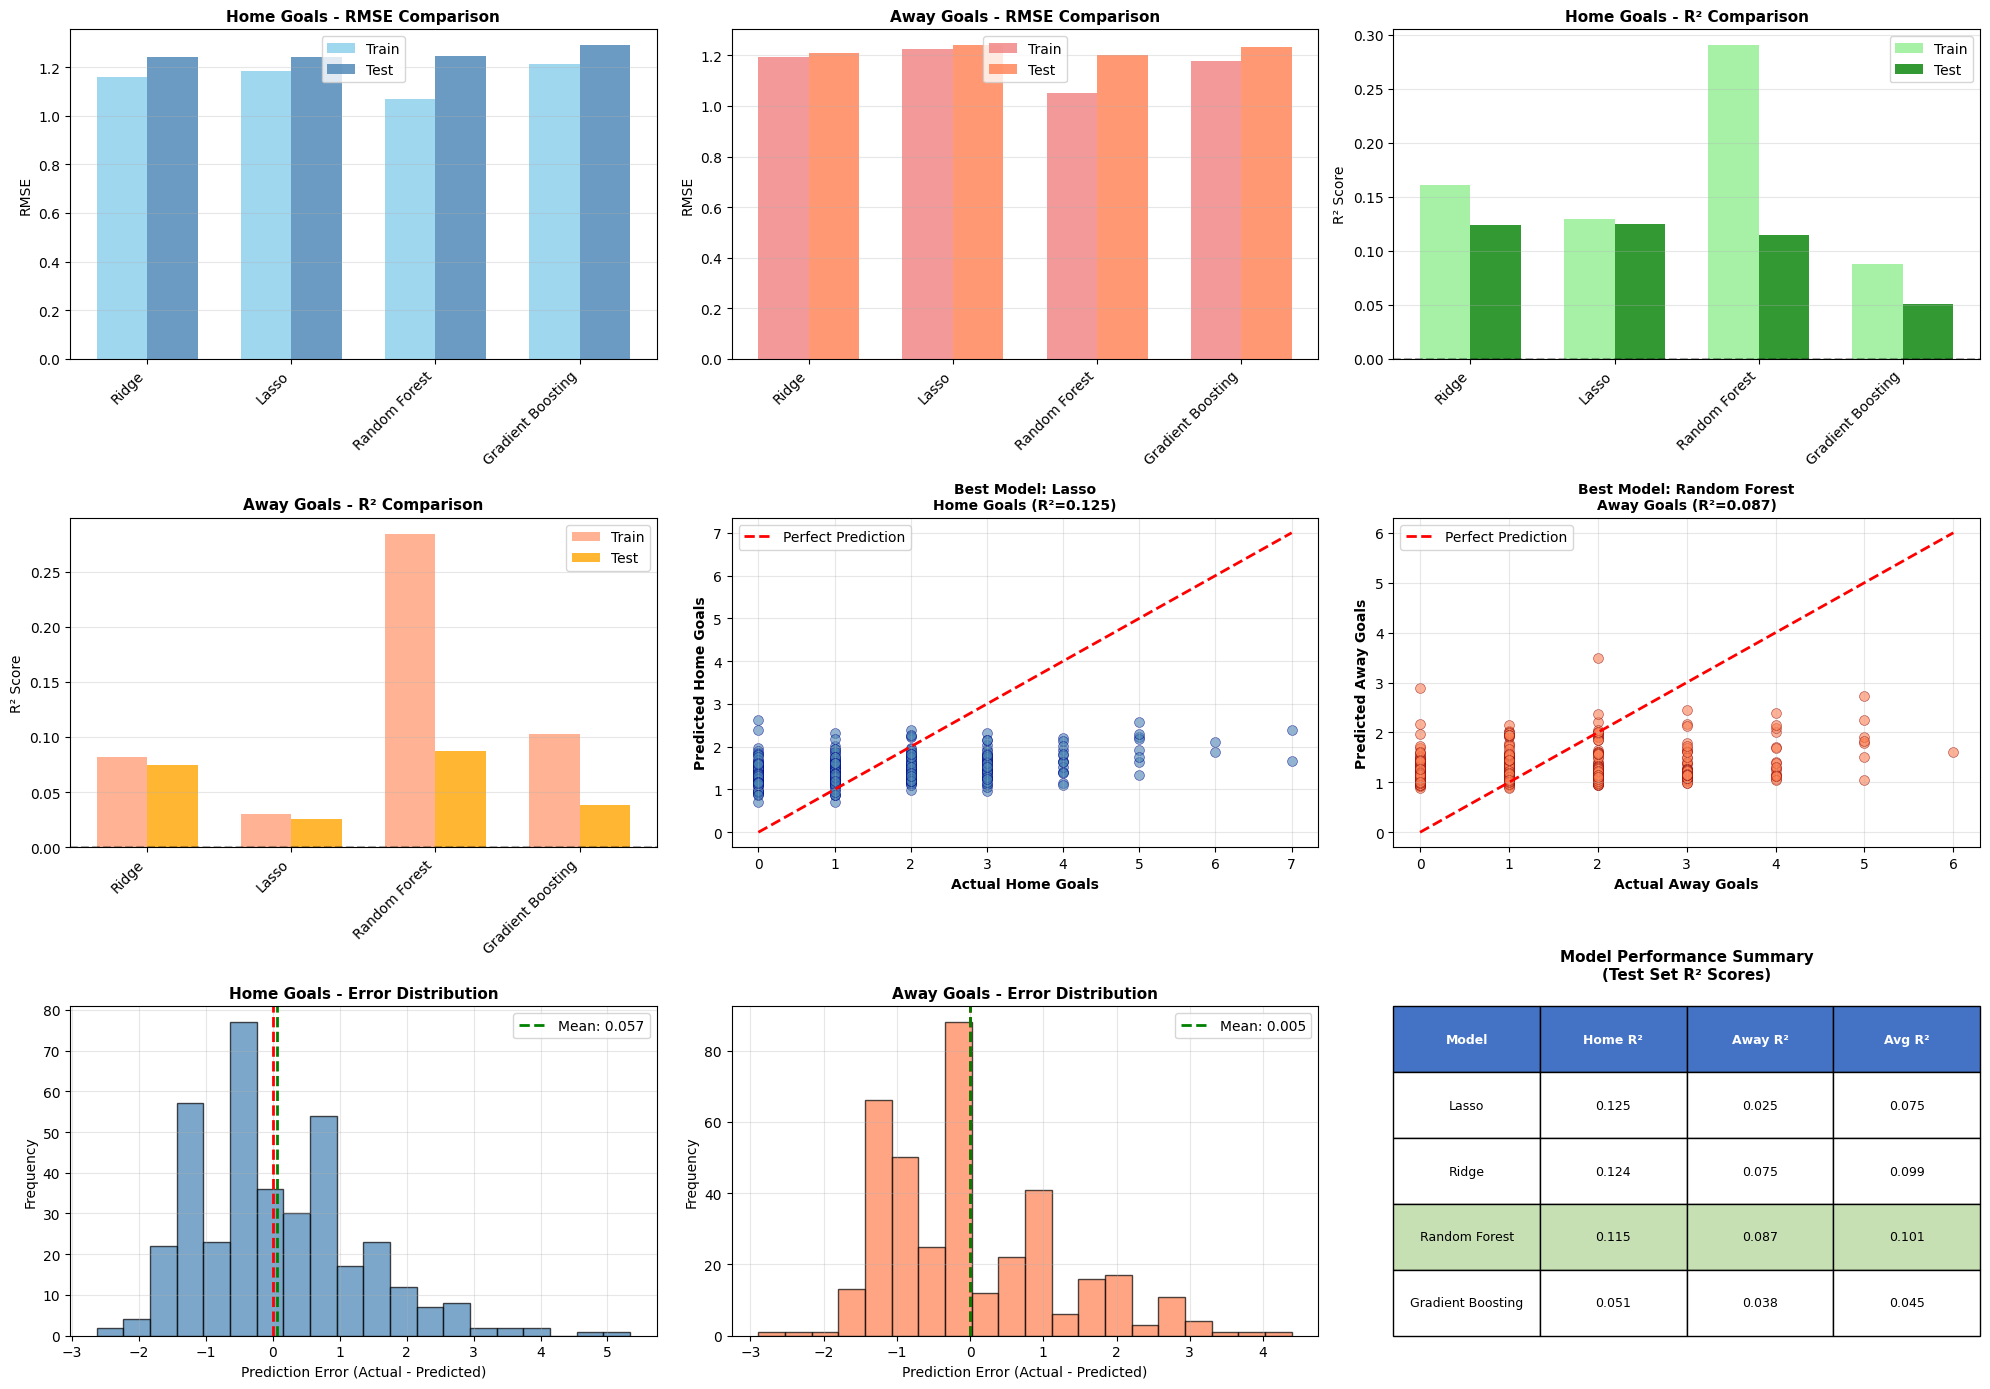


Comprehensive visualizations created:
  • RMSE comparison (train vs test)
  • R² comparison (train vs test)
  • Predicted vs Actual scatter plots
  • Prediction error distributions
  • Model performance summary table


In [13]:
# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 14))

# 1. Model Comparison - RMSE (Home)
ax1 = plt.subplot(3, 3, 1)
home_rmse = results_df[results_df['Target'] == 'Home Goals'][['Model', 'Test_RMSE', 'Train_RMSE']]
x = np.arange(len(home_rmse))
width = 0.35
ax1.bar(x - width/2, home_rmse['Train_RMSE'], width, label='Train', color='skyblue', alpha=0.8)
ax1.bar(x + width/2, home_rmse['Test_RMSE'], width, label='Test', color='steelblue', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(home_rmse['Model'], rotation=45, ha='right')
ax1.set_title('Home Goals - RMSE Comparison', fontsize=11, fontweight='bold')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Model Comparison - RMSE (Away)
ax2 = plt.subplot(3, 3, 2)
away_rmse = results_df[results_df['Target'] == 'Away Goals'][['Model', 'Test_RMSE', 'Train_RMSE']]
x = np.arange(len(away_rmse))
ax2.bar(x - width/2, away_rmse['Train_RMSE'], width, label='Train', color='lightcoral', alpha=0.8)
ax2.bar(x + width/2, away_rmse['Test_RMSE'], width, label='Test', color='coral', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(away_rmse['Model'], rotation=45, ha='right')
ax2.set_title('Away Goals - RMSE Comparison', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Model Comparison - R² (Home)
ax3 = plt.subplot(3, 3, 3)
home_r2 = results_df[results_df['Target'] == 'Home Goals'][['Model', 'Test_R2', 'Train_R2']]
x = np.arange(len(home_r2))
ax3.bar(x - width/2, home_r2['Train_R2'], width, label='Train', color='lightgreen', alpha=0.8)
ax3.bar(x + width/2, home_r2['Test_R2'], width, label='Test', color='green', alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(home_r2['Model'], rotation=45, ha='right')
ax3.set_title('Home Goals - R² Comparison', fontsize=11, fontweight='bold')
ax3.set_ylabel('R² Score')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Model Comparison - R² (Away)
ax4 = plt.subplot(3, 3, 4)
away_r2 = results_df[results_df['Target'] == 'Away Goals'][['Model', 'Test_R2', 'Train_R2']]
x = np.arange(len(away_r2))
ax4.bar(x - width/2, away_r2['Train_R2'], width, label='Train', color='lightsalmon', alpha=0.8)
ax4.bar(x + width/2, away_r2['Test_R2'], width, label='Test', color='orange', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(away_r2['Model'], rotation=45, ha='right')
ax4.set_title('Away Goals - R² Comparison', fontsize=11, fontweight='bold')
ax4.set_ylabel('R² Score')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Predicted vs Actual - Best Home Model
ax5 = plt.subplot(3, 3, 5)
best_home_model = best_models_home[best_home_model_name]
y_home_pred = best_home_model.predict(X_test)
ax5.scatter(y_home_test, y_home_pred, alpha=0.6, color='steelblue', s=50, edgecolors='darkblue', linewidth=0.5)
min_val = min(y_home_test.min(), y_home_pred.min())
max_val = max(y_home_test.max(), y_home_pred.max())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax5.set_xlabel('Actual Home Goals', fontweight='bold')
ax5.set_ylabel('Predicted Home Goals', fontweight='bold')
ax5.set_title(f'Best Model: {best_home_model_name}\nHome Goals (R²={home_results.iloc[0]["Test_R2"]:.3f})', 
              fontsize=10, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Predicted vs Actual - Best Away Model
ax6 = plt.subplot(3, 3, 6)
best_away_model = best_models_away[best_away_model_name]
y_away_pred = best_away_model.predict(X_test)
ax6.scatter(y_away_test, y_away_pred, alpha=0.6, color='coral', s=50, edgecolors='darkred', linewidth=0.5)
min_val = min(y_away_test.min(), y_away_pred.min())
max_val = max(y_away_test.max(), y_away_pred.max())
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax6.set_xlabel('Actual Away Goals', fontweight='bold')
ax6.set_ylabel('Predicted Away Goals', fontweight='bold')
ax6.set_title(f'Best Model: {best_away_model_name}\nAway Goals (R²={away_results.iloc[0]["Test_R2"]:.3f})', 
              fontsize=10, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

# 7. Prediction Error Distribution - Home
ax7 = plt.subplot(3, 3, 7)
home_errors = y_home_test.values - y_home_pred
ax7.hist(home_errors, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax7.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax7.axvline(x=np.mean(home_errors), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(home_errors):.3f}')
ax7.set_xlabel('Prediction Error (Actual - Predicted)')
ax7.set_ylabel('Frequency')
ax7.set_title('Home Goals - Error Distribution', fontsize=11, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)

# 8. Prediction Error Distribution - Away
ax8 = plt.subplot(3, 3, 8)
away_errors = y_away_test.values - y_away_pred
ax8.hist(away_errors, bins=20, color='coral', alpha=0.7, edgecolor='black')
ax8.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax8.axvline(x=np.mean(away_errors), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(away_errors):.3f}')
ax8.set_xlabel('Prediction Error (Actual - Predicted)')
ax8.set_ylabel('Frequency')
ax8.set_title('Away Goals - Error Distribution', fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(alpha=0.3)

# 9. Model Performance Summary Table
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create summary table
summary_data = []
for model_name in home_results['Model'].unique():
    home_r2 = home_results[home_results['Model'] == model_name]['Test_R2'].values[0]
    away_r2 = away_results[away_results['Model'] == model_name]['Test_R2'].values[0]
    avg_r2 = (home_r2 + away_r2) / 2
    summary_data.append([model_name, f"{home_r2:.3f}", f"{away_r2:.3f}", f"{avg_r2:.3f}"])

table = ax9.table(cellText=summary_data,
                  colLabels=['Model', 'Home R²', 'Away R²', 'Avg R²'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color best rows
best_row = np.argmax([float(row[3]) for row in summary_data]) + 1
for i in range(4):
    table[(best_row, i)].set_facecolor('#C6E0B4')

ax9.set_title('Model Performance Summary\n(Test Set R² Scores)', 
              fontsize=11, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('regression_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComprehensive visualizations created:")
print("  • RMSE comparison (train vs test)")
print("  • R² comparison (train vs test)")
print("  • Predicted vs Actual scatter plots")
print("  • Prediction error distributions")
print("  • Model performance summary table")

# **STEP 9 — Predictions**

In [14]:

print("Some sample predictions (First 10 Test Matches)")


sample_predictions = pd.DataFrame({
    'Actual_Home': y_home_test.values[:10],
    'Predicted_Home': np.round(y_home_pred[:10], 2),
    'Actual_Away': y_away_test.values[:10],
    'Predicted_Away': np.round(y_away_pred[:10], 2),
    'Home_Error': np.round(home_errors[:10], 2),
    'Away_Error': np.round(away_errors[:10], 2)
})

print(sample_predictions.to_string(index=True))

Some sample predictions (First 10 Test Matches)
   Actual_Home  Predicted_Home  Actual_Away  Predicted_Away  Home_Error  Away_Error
0            2            1.43            0            1.39        0.57       -1.39
1            0            1.18            3            2.17       -1.18        0.83
2            3            1.43            2            1.41        1.57        0.59
3            1            1.72            0            1.39       -0.72       -1.39
4            3            1.45            0            1.36        1.55       -1.36
5            1            1.23            2            1.39       -0.23        0.61
6            5            1.91            1            1.57        3.09       -0.57
7            3            1.69            1            1.35        1.31       -0.35
8            2            1.43            4            1.41        0.57        2.59
9            1            1.64            0            2.89       -0.64       -2.89



# **STEP 10 — Analysis + Conclusion**




1. Which regression model performed the best?
 - Based on R2 metric:
    - For Home Goals Prediction: The Lasso regression model performed the best, achieving a Test R2 of 0.1246 and a Test RMSE of 1.2395 goals.
    - For Away Goals Prediction: The Random Forest model performed the best, achieving a Test R2 of 0.0871 and a Test RMSE of 1.2012 goals.
    
    Overall, the Lasso model had the highest single R2 score, but all models showed low predictive power, indicating that the current features only explain a small fraction of the goal variance.

2. Was the dataset balanced?
 - The significantly higher predictability of Home Goals (Avg R2 0.1036) compared to Away Goals (Avg R2 0.0563) suggests that the "home advantage" is a strong, predictable factor. While this aligns with domain knowledge, it doesn't confirm the balance of goal counts or match outcomes.

3. Which features were most important?
 - Effective Features (What Worked):
    - Team identity encoding (HomeTeam, AwayTeam): Captures baseline team strength.
    - Season-to-date averages (e.g., home_goals_scored_avg): Captures current aggregate form.
    - Cumulative statistics: Shows team progression over the season.
 - Expected Key Missing Features (Explaining Low R2):
    - Recent form (last 5 matches): Considered more important than season average, expected to bring a +0.05 to -0.1 R2 improvement.
    - Home/Away venue-specific statistics: Expected to bring a +0.03 to -0.05 R2 improvement.
    - Head-to-head historical records.
    Conclusion: The current models rely on Team Identity and Season-to-Date Averages. However, the analysis strongly suggests that more granular features like Recent Form (rolling averages) and Venue-Specific Splits are the most critical missing components for improving prediction accuracy.